# PTB Diagnostic ECG Database Challenge

### Author: Miguel Angel Camara Vazquez

### Date: September 14st, 2022

This Challenge is based on the [PTB Diagnostic ECG Database](https://physionet.org/content/ptbdb/1.0.0/). This database contains 549 ECG recordings from 290 subjects. Each record includes 15 simultaneously measured signals: the conventional 12 leads (i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5, v6) together with the 3 Frank lead ECGs (vx, vy, vz). Signals were recorded with a sampling rate of 1 KHz, and a resolution of 16 bits.

## Part I: Loading, pre-processing, and R-peak detection of the ECG recordings available

This database is not only comprised by the ECG signals, but also by data headers that contains important information about each patient. Since Physionet databases have their own recording format, the easiest way to load both signals and headers is to use the so-called [WFDB-Toolbox](https://physionet.org/content/wfdb-python/4.0.0/), which is able to handle them. Moreover, it enable us to load the ECG signals in the correct physical units (calibration is automatically performed).

In [1]:
# Load basic toolboxes
import os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import wfdb
import ecg_plot
import biosppy as bs

In [2]:
# Define folder path
database_folder = 'Database/'

In [3]:
def filter_resample(signal,fs_orig,fs_final = 100):
    '''
    Returns a filtered and decimated ECG signal.
    
    Parameters:
        signal(array-like, float): ECG recording (n_channels,n_timesteps)
        fs_orig (int): original sampling rate of the input ECG
        fs_final (int): sampling rate to get after decimating the signal.

    Returns:
        sig_resampled (array-like, float): filtered and decimated ECG signal.
    '''
    
    b,a=sc.signal.butter(N=4, Wn = (0.5,40), btype='bandpass',fs=fs_orig) # Coefficients of the BP Butterworth filter
    sig_filt = sc.signal.filtfilt(b,a,signal) # Signal filtering
    sig_resampled = sc.signal.decimate(sig_filt, int(fs_orig/fs_final)) # Signal decimation
    
    return sig_resampled

This database contains recordings from patients with the following cardiac pathologies:
- Myocardial infarction: 148 patients.
- Cardiomyopathy/Heart failure: 18 patients.
- Bundle branch block: 15 patients.
- Dysrhythmia: 14 patients.
- Myocardial hypertrophy: 7 patients.
- Valvular heart disease: 6 patients.
- Myocarditis: 4 patients.
- Miscellaneous: 4 patients.
- Healthy controls: 52 patients.

This information is not only available in the documentation of the database, but also in the headers of each ECG recording. To load each ECG recording, the WFDB toolbox generates an object with different attributes. The ones that are important to us are the following ones:
- p_signal: it contains a numpy array with the associated 15 ECG leads.
- sig_name: it contains the names of each ECG lead.
- fs: sampling rate of the signals.
- comments: it contains some information about the patient. The most important field here is the 4th one, which describes the reason for admission, i.e., the cardiac pathology involved.

In order to simplify the data pre-processing process, we will assign a numerical label to each pathology. We have to take into account that some of the recordings does not have a reason for admission (n/a), we will discard those which do not have that information. Final number of ECG recordings will be 522.

Finally, we will apply the following pre-processing procedure to the 15 ECG leads:
1. Signals will be filtered with a 4th-order bandpass Butterworth filter, with cutoff frequencies of 0.5 and 40Hz.
2. Since the typical frequency band for ECG signals range from 0.5 to 40 Hz, we will also resample the signals to a sampling rate of 100Hz. The main aim to do so is also to increase the computation speed.

In [4]:
records = [] # Empty list to store the ECG recordings
labels = [] # Empty list to store the ECG labels

fs = 100 # Final sampling rate

for path, subdirs, files in os.walk(database_folder): # Iteration through the database folders.
    for name in files:
        if name.endswith(".dat"): # ECG recordings are stored in .dat files.
            record = wfdb.rdrecord(os.path.splitext(os.path.join(path, name))[0]) # Data loading using WFDB
            sigs = (record.p_signal).T # Dims: (nchannels,t_instants)
            leads = record.sig_name # Names associated to each ECG lead
            fs_orig = record.fs # Original sampling rate
            diag = (record.comments[4]).lower() # Conversion of the reason for admision to low-case.
            
            # Conversion of each pathology category to a numeric label
            if 'healthy' in diag:
                label = 0
            elif 'infarction' in diag:
                label = 1
            elif ('cardiomyopathy' in diag) or ('failure' in diag):
                label = 2
            elif 'branch' in diag:
                label = 3
            elif 'dysrhythmia' in diag:
                label = 4
            elif 'valvular' in diag:
                label = 5
            elif 'myocarditis' in diag:
                label = 6
            elif 'hypertrophy' in diag:
                label = 7
            elif 'n/a' in diag:
                continue
            else:
                label = 8
                print(os.path.join(path, name)) # Print those miscellaneous pathologies.
                print(diag)
            
            records.append(filter_resample(sigs,fs_orig)) # Store each decimated and filtered recording in a list.
            labels.append(label) # Store each label in a list.

Database/patient196/s0002_re.dat
reason for admission: unstable angina
Database/patient191/s0340lre.dat
reason for admission: stable angina
Database/patient130/s0166_re.dat
reason for admission: stable angina
Database/patient126/s0154_re.dat
reason for admission: palpitation


In [5]:
# Double-check to be sure that we have exactly the same number ot records and labels
print(len(records)==len(labels))
print(len(records))

# Final counting of each type of recording
print(labels.count(0))
print(labels.count(1))
print(labels.count(2))
print(labels.count(3))
print(labels.count(4))
print(labels.count(5))
print(labels.count(6))
print(labels.count(7))
print(labels.count(8))

True
522
80
368
20
17
16
6
4
7
4


Once we have loaded and pre-processed the signals, it is time to plot some of the ECG recordings. Instead of plotting them using a simple figure, we will use the [ECG-Plot](https://github.com/dy1901/ecg_plot) toolbox, since it is able to show a standard clinical-like ECG chart.

To make visualization easier, we will plot just 5 seconds of two recordings.

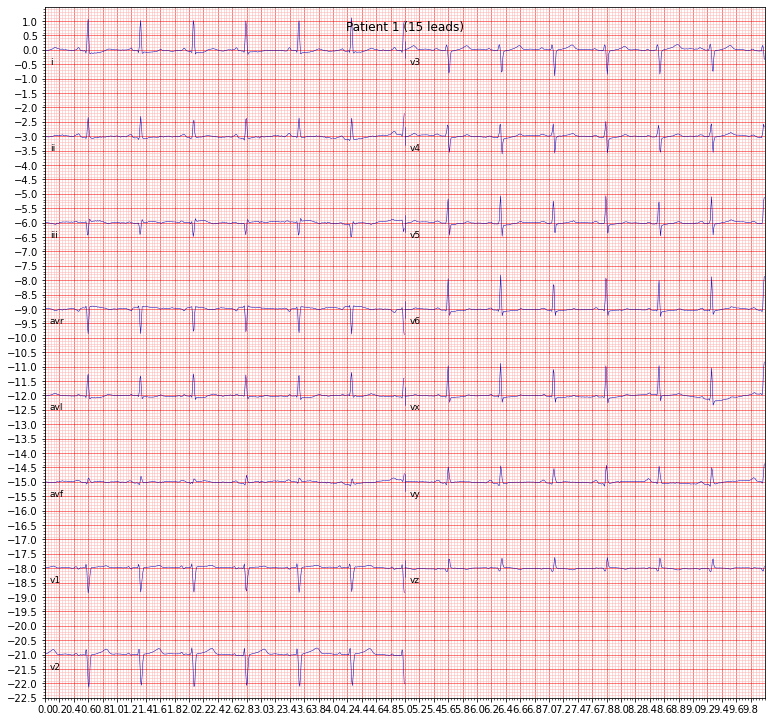

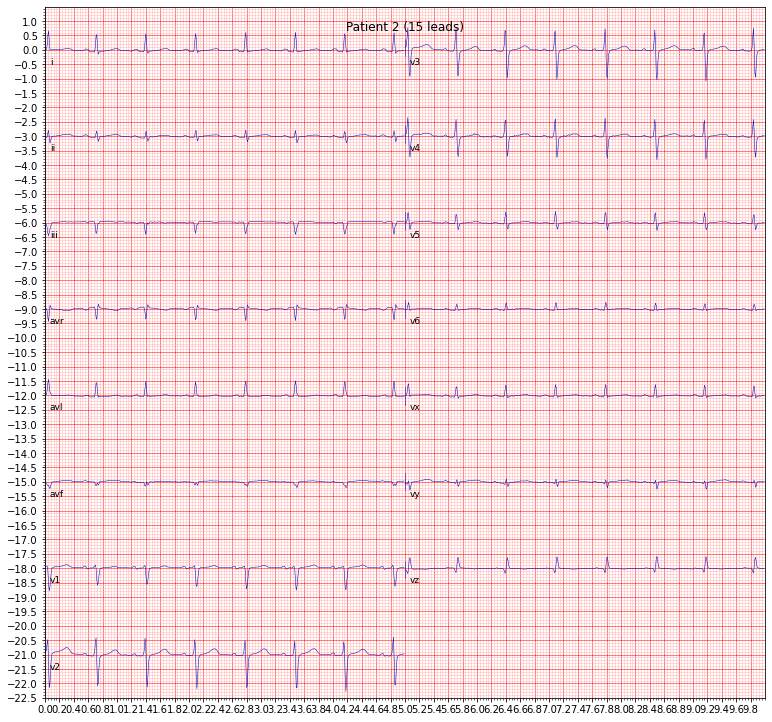

In [6]:
# Using ECG_plot to plot a standard ECG chart.
ecg_plot.plot(ecg=records[0][:,:500], sample_rate = fs, lead_index = leads, title='Patient 1 (15 leads)')
ecg_plot.plot(ecg=records[100][:,:500], sample_rate = fs, lead_index = leads, title='Patient 2 (15 leads)')

Now, it is time to characterize the heart rhythm in each patient. The most straightforward way to get a simple descriptor of how the heart rhythm is in each patient, is by computing the R-R intervals. To do that, we should locate the position in which the R-peak is in each of the QRS complexes availables in the signal.

There are many ways to locate R-peaks, but one of the most used ones is the Pan-Tompkins algorithm. In our case, we will use the [Hamilton segmenter](https://www.cinc.org/old/Proceedings/2002/pdf/101.pdf), which is a modification of the previously mentioned one. This algorithm is already implemented in the [BioSPPy Toolbox](https://biosppy.readthedocs.io/en/stable/index.html), which is a toolbox for biosignal processing.

This algorithm is designed to be used on a standard Lead I ECG, so we will use this lead in the next steps.

In [7]:
# Using the Hamilton segmenter to detect R-peaks in two different recordings.
# BE CAREFUL: it is just useful on Lead I.
R_peaks_1 = bs.signals.ecg.hamilton_segmenter(signal=records[0][0,:], sampling_rate=fs)
R_peaks_2 = bs.signals.ecg.hamilton_segmenter(signal=records[100][0,:], sampling_rate=fs)

Number of R-peaks in Patient 1: 158
Number of R-peaks in Patient 2: 169
Average cardiac rhythm in Patient 1: 82 bpm
Average cardiac rhythm in Patient 2: 88 bpm


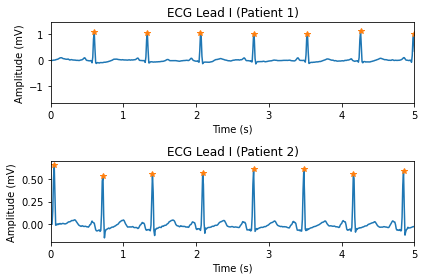

In [8]:
# Plot two ECG recordings (lead I) with marked R-peaks.

# A times vector is needed to plot the signals in seconds (x-axis)
t_vector_1 = np.linspace(0,records[0].shape[1]/fs,records[0].shape[1])
t_vector_2 = np.linspace(0,records[100].shape[1]/fs,records[100].shape[1])

plt.figure()
plt.subplot(211)
plt.plot(t_vector_1, records[0][0,:]) # Plot the first ECG signal
plt.xlim(0,5)
plt.plot(t_vector_1[R_peaks_1],records[0][0,R_peaks_1].ravel(),'*') # Put markers in each of the R-peaks
plt.title('ECG Lead I (Patient 1)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.subplot(212)
plt.plot(t_vector_2, records[100][0,:]) # Plot the second ECG signal
plt.xlim(0,5)
plt.plot(t_vector_2[R_peaks_2],records[100][0,R_peaks_2].ravel(),'*') # Put markers in each of the R-peaks
plt.title('ECG Lead I (Patient 2)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.tight_layout()

# Analysis of the number of R-peaks (beats) detected
print('Number of R-peaks in Patient 1: '+str(len(R_peaks_1[0])))
print('Number of R-peaks in Patient 2: '+str(len(R_peaks_2[0])))

# Analysis of the number of the average cardiac rhythm
print('Average cardiac rhythm in Patient 1: '+str(int(60*len(R_peaks_1[0])/t_vector_1[-1]))+' bpm')
print('Average cardiac rhythm in Patient 2: '+str(int(60*len(R_peaks_2[0])/t_vector_2[-1]))+' bpm')

This R-peaks detection has been made in two random recordings until now. However, in the next part of the Notebook we will use this methodology to do a far more interesting task.

## Part II: Classification of ECGs using Machine Learning
Ok, what we have done is just to load, pre-process, and visualize the ECG signals from the given database, including the computation of the R-waves. Moreover, we have loaded the type of arrhytmias associated to each recording. Therefore... what if we try to create a very simple ECG classifier?

To do that, we need to look for some characteristics that could describe the arrhytmic behavior. If we read the definition of [cardiac arrhythmia](https://www.nhlbi.nih.gov/health/arrhythmias):

*An arrhythmia, or irregular heartbeat, is a problem with the rate or rhythm of your heartbeat. Your heart may beat too quickly, too slowly, or with an irregular rhythm.*

We can easily conclude that the main ECG parameter that can be affected in an arrhytmia is the pace, i.e., the variability of the R-R intervals. So:
- If the variability of the R-R intervals for a certain record is small, we can conclude that the heart rhythm is stable.
- On the opposite, if the variability of the R-R intervals is high, the heart rhythm will not stable at all.

The variability can be measured with the standard deviation of the R-R intervals. However, is the variability of the R-R intervals the only parameter to be considered to discuss if an ECG has an arrhytmic behavior or not? Bradicardia or tachycardia indicates an abormal slow or fast cardiac rhythm, respectively. Moreover, some supraventricular arrhythmias, like atrial fibrillation or atrial flutter, can have an stable heart rhythm in some cases, but with an abnormal ECG morphology and cardiac rhythm. Therefore, the mean of the R-R intervals can be also a characteristic of interest to be considered.

As we have mentioned, the morphology of the ECG signal is one of the most important aspects to be analyzed when diagnosing a cardiac arrhytmia. The morphology of the ECG leads can be analyzed using the Fourier transform, since each of the typical synus-rhythm ECG waves is associated to a certain frequency ranges:
- P wave: between 0.5 and 12Hz.
- T wave: between 0.5 and 6Hz.
- QRS complex: between 5 and 25Hz.

Thus, changes in the Power Spectral Density (PSD) of the ECG in each of these frequency bands can be used to describe cardiac arrhytmias. Therefore, spectral power ratios can be useful.

Once we have explained some possible descriptors, let's compute them!

### Computation of ECG descriptors

* **RR-intervals-based characteristics:** mean and standard deviation of the R-R intervals. We will use a similar methodology as in the first part of this work.

Once we have computed the position of the R-peaks (in seconds), we can apply the diff function of numpy to compute the associated R-R intervals, including their mean and standard deviation.

In [9]:
## Computing the average and standard deviation of R-R intervals. Only Lead I will be used.
mean_RR_intervals = [] # List to store the mean of the RR intervals.
std_RR_intervals = [] # List to store the standard deviation of the RR intervals.

for record in records: # RR-interval analysis for each ECG recording
    leadI = record[0,:] # Get the lead I
    # Hamilton segmenter is used to compute the position of the RR peaks.
    # Then, a diff function is used to compute the RR intervals (diff between consecutive RR peaks)
    RR = np.diff(bs.signals.ecg.hamilton_segmenter(signal = leadI, sampling_rate=fs))/fs # 
    mean_RR = np.mean(RR) # Computing the average RR interval
    std_RR = np.std(RR) # Computing the standard deviation of the RR intervals
    if np.isnan(mean_RR):  # WARNING: NaNs can appear due to a bad function of the Hamilton segmenter (no RR peaks detected: possible arrhythmia)
        mean_RR_intervals.append(0) # Mean and std are set to 0 in this case
        std_RR_intervals.append(0)
    else:
        mean_RR_intervals.append(mean_RR) # Store the mean RR interval for each record in a list
        std_RR_intervals.append(std_RR) # Store the standard deviation of RR intervals for each record in a list.

/home/macamara/miniconda3/envs/Research/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/macamara/miniconda3/envs/Research/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/macamara/miniconda3/envs/Research/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/macamara/miniconda3/envs/Research/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/macamara/miniconda3/envs/Research/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret 

* **Spectral-based descriptors:** PSD-based characteristics should be computed for each lead available, since there are cardiac arrhythmias that are visible in some leads and not in others.

To compute spectral ratios, we will use the following procedure:
1. First, we will compute the Welch's periodogram in order to get a PSD estimation.
2. Then, we will compute the total average power of the signal. It is defined as the enclosed area inside the PSD.
3. Similarly, we will compute the total average power of the signal, but just in the frequency bands that are related to the P-wave, T-wave, and QRS-complex.
4. Finally, we will compute the ratio between total average power in a certain frequency band, and the total average power of the signal.

We will compute 45 features: 15 ECG x 3 descriptors.

In [10]:
## Computing spectral ratios of each ECG recording. # We will use the 15 available leads.
P_wave_ratios = [] # List to store P-wave spectral ratios
T_wave_ratios = [] # List to store T-wave spectral ratios
QRS_complex_ratios = [] # List to store QRS-complex spectral ratios

for record in records: # spectral analysis for each ECG recording
    # Computing the Welch periodogram for each record (3 seconds per window)
    f,Pxx = sc.signal.welch(record, fs=fs, window = 'hamming', nperseg = 300, nfft = 512)
    # Average total power for each signal (integral of the PSD)
    tot_av_pow = sc.integrate.simpson(Pxx,f)

    # Ratio average total power in the P-wave frequency range vs Average total power
    f_low_P = np.argmin(np.abs(f-0.5)) # Index of the closest frequency value to 0.5
    f_high_P = np.argmin(np.abs(f-12)) # Index of the closest frequency value to 12
    # Average total power for each signal (integral of the PSD) between 0.5 and 12 Hz
    ratio_pow_P = (sc.integrate.simpson(Pxx[:,f_low_P:f_high_P],f[f_low_P:f_high_P]))/tot_av_pow 

    # Ratio average total power in the T-wave frequency range vs Average total power
    f_low_T = np.argmin(np.abs(f-0.5)) # Index of the closest frequency value to 0.5
    f_high_T = np.argmin(np.abs(f-6)) # Index of the closest frequency value to 6
    # Average total power for each signal (integral of the PSD) between 0.5 and 6 Hz
    ratio_pow_T = (sc.integrate.simpson(Pxx[:,f_low_T:f_high_T],f[f_low_T:f_high_T]))/tot_av_pow

    # Ratio average total power in the QRS-complex frequency range vs Average total power
    f_low_QRS = np.argmin(np.abs(f-5)) # Index of the closest frequency value to 0.5
    f_high_QRS = np.argmin(np.abs(f-25)) # Index of the closest frequency value to 6
    # Average total power for each signal (integral of the PSD) between 5 and 25 Hz
    ratio_pow_QRS = (sc.integrate.simpson(Pxx[:,f_low_QRS:f_high_QRS],f[f_low_QRS:f_high_QRS]))/tot_av_pow
    
    # Concatenate these ratios in a single list
    P_wave_ratios.append(ratio_pow_P)
    T_wave_ratios.append(ratio_pow_T)
    QRS_complex_ratios.append(ratio_pow_QRS)
    
# Lists with ratios are converted to numpy arrays
P_wave_ratios =np.array(P_wave_ratios)
T_wave_ratios =np.array(T_wave_ratios)
QRS_complex_ratios =np.array(QRS_complex_ratios)

### Computation of a feature matrix

Once we have computed some ECG descriptors, it is time to build a feature matrix, since it will be the input data for the different ML algorithms that will be tested in this Challenge.

This matrix should have as many rows as available ECG recordings, and as many columns as descriptors. Therefore, a 2D concatenation of descriptors has to be made. The dimensions of our feature matrix should be (522,47), since we have 522 ECG recordings and a total number of 47 features.

In [11]:
# Concatenation of the different ECG descriptors in a single matrix
X = [] # Features list
X.append(mean_RR_intervals) # First we add the mean RR intervals
X.append(std_RR_intervals) # Then we add the standard deviation of the RR intervals
X = np.array(X).T # Conversion of the X list into an array
# Concatenation of the X array with the spectral descriptors
X = np.concatenate((X, P_wave_ratios, T_wave_ratios, QRS_complex_ratios),axis=-1) 
    
Y = np.array(labels).ravel() # Labels are converted to one-dimensional array.

# Double-check of X and Y shapes
print(X.shape)
print(Y.shape)

(522, 47)
(522,)


### Train-test-split and feature selection

One of the most important procedures to be made in a ML project is to properly select the data we will use to train our models. We will use some supervised algorithms, since our dataset was properly labeled.

To create our training dataset for these algorithms, we should randomly split the feature matrix into training and test. In the majority of ML projects we usually assign the 80% of data to training and 20% to test. However, our dataset is very imbalanced, since the number of recordings associated to myocardial infarction is more than 3 times the number of healthy controls (and even more if we compare that number to the other represented pathologies).

Therefore, we will perform an [stratified](https://scikit-learn.org/stable/modules/cross_validation.html#stratification) train-test-split, so we can keep a certain proportion of each class in the test set. This procedure will be carried out using [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [12]:
from sklearn.model_selection import train_test_split
# Split the dataset into train (80%) and test (20%) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

Once we have divided our dataset into training and test set, it is time to perform a feature selection procedure. Although theoretically the ECG descriptors computed are well justified, they should be mathematically meaningful, i.e., they should help to properly discriminate between different populations. Moreover, feature selection procedures can be also used to reduce the dimensionality of data, which can increase the computation efficiency and the interpretation of the ML model.

There are different ways to compute a [feature selection](https://scikit-learn.org/stable/modules/feature_selection.html):
- By variance threshold: if a feature has a low variance, it can indicate that its values are very similar independendly of the population considered.
- F-test-based tests: they estimate the degree of linear dependency between two random variables.
- Tree-based estimators: they can be used to compute impurity-based feature importances.

Since this work is just preliminary, we will only use a tree-based estimator, which is a type of ensemble learning technique which aggregates the results of multiple non-correlated decision trees collected to output a classification result. It is very important to do it using just the training set, since it is the one in which we will have a-priori knowledge of the labels.

Once we have performed the feature selection process, we will get a feature matrix with half of the features, approx.

In [13]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50) # Define a Extremely Randomized Trees Classifier with 50 estimators
clf = clf.fit(X_train, y_train) # Fit the classifier

model = SelectFromModel(clf, prefit=True) # Create a SelectFromModel instance to get the most important features.
X_train = model.transform(X_train) # Obtention of the final X_train matrix (with removed unmeaningful features)
X_test = model.transform(X_test) # Obtention of the final X_test matrix (with removed unmeaningful features)

# Double-check of the X_train and X_test matrices shape
print(X_train.shape)     
print(X_test.shape)

(417, 18)
(105, 18)


### Training of Machine Learning models

Now, it is time to test some Machine Learning algorithms to see if they are useful or not to classify cardiac arrhythmias. There are many types of ML supervised classifiers, so we will use just three of them:
* [Decision trees](https://scikit-learn.org/stable/modules/tree.html): its goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. It is easy to understand and to interpret, but it can create over-complex trees that do not generalize the data well.
* [Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html): the Bayes’ theorem is applied with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. It is a fast classifier, but it is known to be a bad estimator of the output probabilities.
* [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html): they use hyperplanes to separate different poblations of data. It is quite effective in high dimensional spaces, but if over-fitting relies in a correct Kernel function and regularization term.

Let's see what we obtain...

**Decision tree classifier**

In [14]:
from sklearn import tree
dt_classifier = tree.DecisionTreeClassifier() # Define a simple decision tree classifier
dt_classifier.fit(X_train, y_train) # Fit the classifier

DecisionTreeClassifier()

Obtained accuracy (training set): 1.0
Obtained accuracy (test set): 0.6476190476190476


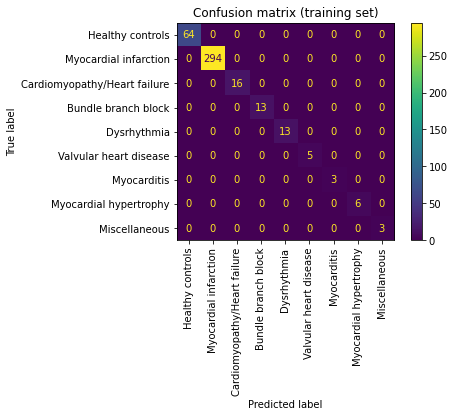

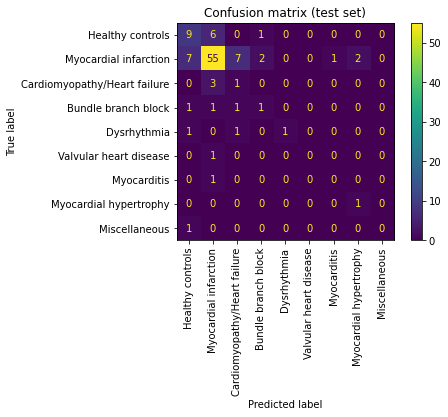

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# Display the confusion matrix for the training set
target_labels = ['Healthy controls', 'Myocardial infarction', 'Cardiomyopathy/Heart failure','Bundle branch block','Dysrhythmia', 'Valvular heart disease', 'Myocarditis', 'Myocardial hypertrophy', 'Miscellaneous']
ConfusionMatrixDisplay.from_estimator(
    dt_classifier, X_train, y_train, display_labels=target_labels, xticks_rotation="vertical"
)
plt.title('Confusion matrix (training set)')

# Display the confusion matrix for the test set
ConfusionMatrixDisplay.from_estimator(
    dt_classifier, X_test, y_test, display_labels=target_labels, xticks_rotation="vertical"
)
plt.title('Confusion matrix (test set)')

# Overall accuracy values for the training and test sets
print('Obtained accuracy (training set): '+str(accuracy_score(y_train, dt_classifier.predict(X_train))))
print('Obtained accuracy (test set): '+str(accuracy_score(y_test, dt_classifier.predict(X_test))))

**Naïve Bayes**

In [16]:
from sklearn.naive_bayes import GaussianNB
NB_classifier = GaussianNB() # Define a Gaussian Naive Bayes classifier
NB_classifier.fit(X_train, y_train) # Fit the classifier

GaussianNB()

Obtained accuracy (training set): 0.5731414868105515
Obtained accuracy (test set): 0.4857142857142857


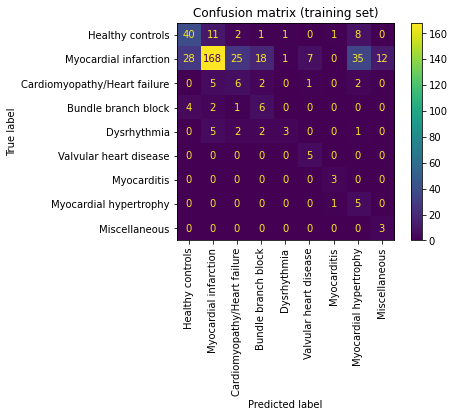

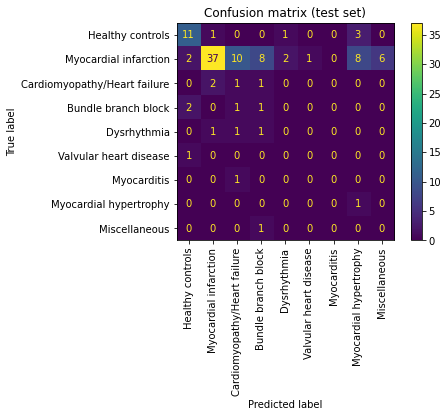

In [17]:
# Display the confusion matrix for the training set
ConfusionMatrixDisplay.from_estimator(
    NB_classifier, X_train, y_train, display_labels=target_labels, xticks_rotation="vertical"
)
plt.title('Confusion matrix (training set)')

# Display the confusion matrix for the test set
ConfusionMatrixDisplay.from_estimator(
    NB_classifier, X_test, y_test, display_labels=target_labels, xticks_rotation="vertical"
)
plt.title('Confusion matrix (test set)')

# Overall accuracy values for the training and test sets
print('Obtained accuracy (training set): '+str(accuracy_score(y_train, NB_classifier.predict(X_train))))
print('Obtained accuracy (test set): '+str(accuracy_score(y_test, NB_classifier.predict(X_test))))

**SVC**

In [18]:
from sklearn.svm import SVC
SVC_classifier = SVC(gamma='auto') # Define a Support Vector Machine-based classifier
SVC_classifier.fit(X_train, y_train) # Fit the classifier

SVC(gamma='auto')

Obtained accuracy (training set): 0.7050359712230215
Obtained accuracy (test set): 0.7047619047619048


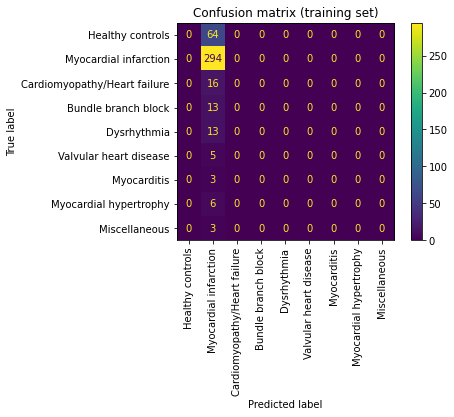

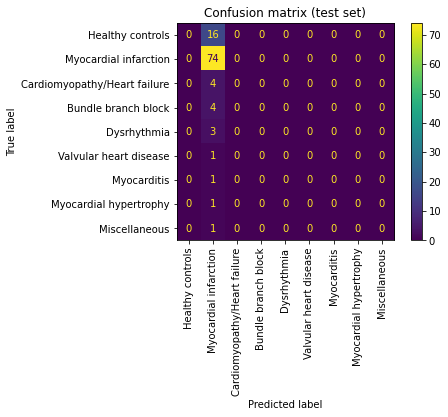

In [19]:
# Display the confusion matrix for the training set
ConfusionMatrixDisplay.from_estimator(
    SVC_classifier, X_train, y_train, display_labels=target_labels, xticks_rotation="vertical"
)
plt.title('Confusion matrix (training set)')

# Display the confusion matrix for the test set
ConfusionMatrixDisplay.from_estimator(
    SVC_classifier, X_test, y_test, display_labels=target_labels, xticks_rotation="vertical"
)
plt.title('Confusion matrix (test set)')

# Overall accuracy values for the training and test sets
print('Obtained accuracy (training set): '+str(accuracy_score(y_train, SVC_classifier.predict(X_train))))
print('Obtained accuracy (test set): '+str(accuracy_score(y_test, SVC_classifier.predict(X_test))))

### Analysis of the results

The first metric we will use to assess the performance of the proposed ML models is the accuracy. It is defined as the proportion of well-classified examples over the total population. According to this metric, the best model is the Support Vector Classifier, since it achieved an accuracy of 0.7 in the test set. However, does it means that the SVC is a good classifier?

As we have discussed before, our dataset is highly imbalanced, so we need the big picture of how are the different labels classified. Therefore, we need to analyze the confusion matrices.

What we can conclude from these matrices is that the myocardial infarction is perfectly classified with the SVC algorithm (that means that the sensitivity for this category is 100%), whereas the decision tree and Naive Bayes classifiers were able to correctly classify a percentage of 74% and 50%, respectively. However, results get much worse when analyzing the rest of the categories associated to cardiac pathology. The SVC was completely unable to correctly classify those pathologies, whereas the Naive Bayes was able to predict correctly the only subject in the myocardial hypertrophy category and the 25% of cases with bundle branch block. Finally, the decision tree was able to correctly classify the 37% of cases with cardiomyopathy. These are very bad results, but they make sense since those categories are much less represented than the myocardial infarction were expected (this category is the most represented in our population).

Let's move one step forward, let's imagine that we want to create a screening algorithm. What we need is to correctly classify the most of healthy patients, since an error of the algorithm in this category will mean that a sick person could die as he/she is not well identified to have a cardiac pathology. Therefore, what we are going to do is to compare the performance of the classifier depending on the classification in healthy-sick. 

Mathematically, what we are going to do is to compute the specificity of the classifier, considering the healthy controls as negative in the screening test. The specificity represents the proportion of real negative subjects over the whole number of negatives. In this scenario, the specificity for each classifier was:
* Decision tree: 56%
* Naive Bayes: 68%
* SVC: 0%

With these results, we can conclude that neither of them can be considered as good choices of screening algorithms, since the proportion of healthy subjects that are correctly classified is slightly superior to 1/2.

## Part III: Classification using LSTM networks

We have seen different feature-based ML methods so far. These methods rely on how good or bad are the extracted features when trying to describe the examples, and they require to select and compute them manually. However, working with a great amount of signals and patients makes this procedure very time-consuming.

To solve this problem, Deep Learning models make data-driven predictions by using multiple non-linear transformations to yield abstract representations of data. Therefore, DL methos are able to learn directly from raw data, avoiding the previous step of computing a priori features.

We are not going to explain in detail the insights of Deep Learning and Neural Networks. What we are going to do is to focus on Recurrent Neural Networks (RNN) architectures, which are the ones that we are going to use in the next steps.

RNN are a family of neural networks for sequence data processing and modeling very popular in natural language processing (NLP) and signal applications. This architectures enables an appropriate generalization across the different samples of the signal. However, RNN have problems when dealing with very long sequencies. LSTM architectures overcomes this issue, since they include mechanisms to selectively forget or update the information that is propagated across the network.

Therefore, what we are going to do is to use Tensorflow and Keras to create a very simple LSTM architecture, in order to predict the category to which ECG recording belongs. To do that, we first need to correctly set up the input matrices. In this case, we need to organize the recordings in matrices with dimensions (1, n_timesteps, n_features). Each record will be stored in a list. Then, we will split the dataset into training and test, exactly in the same way as we have done before. Finally, since the output will be a categorical variable, Keras requires to convert the labels to a one-hot numeric array. 

Let's do this!

In [20]:
import tensorflow as tf
X = []
for record in records:
    X.append(record.T.reshape(1,record.shape[1],record.shape[0]))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=9)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=9)

One important advantage that RNN architectures has is the possibility of dealing with variable timeseries lenghts. This is exactly our case (each recording has a different duration). However, it requieres to fed the network to one recording at a time. Therefore, we will create a very simple Python generator that will generate a tuple structure with a single recording (15 leads) and its respective label.

In [21]:
def X_generator(X,Y):
    '''
    Returns a filtered and decimated ECG signal.
    
    Parameters:
        X(list, float): list with ECG recordings. Each record in the list should have (1, n_timesteps, n_channels) dimensions.
        Y(array-like, float): ECG labels (in OneHotEncoding format)

    Yield:
        sig_resampled (array-like, float): filtered and decimated ECG signal.
    '''
    while True: # The generator should be reset once we have iterated throughout the whole number of ECG recordings
        for i in range(len(X)): # For-loop to iterate throughout the recording list
            yield((X[i],Y[i].reshape(1,9))) # Yield a tuple with (ECG record, corresponding ECG label)

In [22]:
steps_train = len(X_train) # Number of recordings, i.e., number of steps per epoch (each epoch should "see" all ECG recordings)
train_gen = X_generator(X_train,y_train) # Create a generator with the training data

Finally, we will create and fit a simple LSTM-based network. Let's see what happens!

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Design the LSTM-based network
model = Sequential()
model.add(LSTM(10, input_shape=(None,15))) # LSTM layer with 10 units and not-defined timesteps (it depends on the recording)
model.add(Dense(9,activation='softmax')) # Multi-classification require a softmax activation function
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

2022-09-14 19:27:19.305418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 19:27:19.306306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 19:27:19.332917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 19:27:19.333830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-14 19:27:19.334669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                1040      
                                                                 
 dense (Dense)               (None, 9)                 99        
                                                                 
Total params: 1,139
Trainable params: 1,139
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Fit the network
history = model.fit(train_gen,epochs=200,steps_per_epoch=steps_train)

Epoch 1/200


2022-09-14 19:27:21.820661: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


417/417 [==============================] - 67s 158ms/step - loss: 1.3662 - accuracy: 0.6811
Epoch 2/200
417/417 [==============================] - 65s 157ms/step - loss: 1.0634 - accuracy: 0.7050
Epoch 3/200
417/417 [==============================] - 65s 157ms/step - loss: 1.0529 - accuracy: 0.7050
Epoch 4/200
417/417 [==============================] - 66s 157ms/step - loss: 1.0448 - accuracy: 0.7050
Epoch 5/200
417/417 [==============================] - 66s 157ms/step - loss: 1.0390 - accuracy: 0.7050
Epoch 6/200
417/417 [==============================] - 66s 157ms/step - loss: 1.0358 - accuracy: 0.7074
Epoch 7/200
417/417 [==============================] - 66s 158ms/step - loss: 1.0326 - accuracy: 0.7098
Epoch 8/200
417/417 [==============================] - 66s 158ms/step - loss: 1.0299 - accuracy: 0.7146
Epoch 9/200
417/417 [==============================] - 66s 158ms/step - loss: 1.0272 - accuracy: 0.7146
Epoch 10/200
417/417 [==============================] - 66s 158ms/step - los

417/417 [==============================] - 68s 163ms/step - loss: 0.9177 - accuracy: 0.7266
Epoch 80/200
417/417 [==============================] - 67s 162ms/step - loss: 0.9164 - accuracy: 0.7266
Epoch 81/200
417/417 [==============================] - 67s 162ms/step - loss: 0.9144 - accuracy: 0.7314
Epoch 82/200
417/417 [==============================] - 67s 161ms/step - loss: 0.9125 - accuracy: 0.7314
Epoch 83/200
417/417 [==============================] - 68s 162ms/step - loss: 0.9102 - accuracy: 0.7338
Epoch 84/200
417/417 [==============================] - 67s 161ms/step - loss: 0.9080 - accuracy: 0.7362
Epoch 85/200
417/417 [==============================] - 68s 162ms/step - loss: 0.9049 - accuracy: 0.7362
Epoch 86/200
417/417 [==============================] - 68s 163ms/step - loss: 0.9004 - accuracy: 0.7386
Epoch 87/200
417/417 [==============================] - 68s 162ms/step - loss: 0.8936 - accuracy: 0.7458
Epoch 88/200
417/417 [==============================] - 68s 163ms/st

417/417 [==============================] - 68s 163ms/step - loss: 0.9088 - accuracy: 0.7266
Epoch 157/200
417/417 [==============================] - 68s 164ms/step - loss: 0.9083 - accuracy: 0.7266
Epoch 158/200
417/417 [==============================] - 68s 164ms/step - loss: 0.9078 - accuracy: 0.7266
Epoch 159/200
417/417 [==============================] - 68s 164ms/step - loss: 0.9074 - accuracy: 0.7266
Epoch 160/200
417/417 [==============================] - 68s 164ms/step - loss: 0.9070 - accuracy: 0.7266
Epoch 161/200
417/417 [==============================] - 68s 163ms/step - loss: 0.9066 - accuracy: 0.7266
Epoch 162/200
417/417 [==============================] - 68s 162ms/step - loss: 0.9062 - accuracy: 0.7266
Epoch 163/200
417/417 [==============================] - 67s 162ms/step - loss: 0.9058 - accuracy: 0.7266
Epoch 164/200
417/417 [==============================] - 67s 162ms/step - loss: 0.9054 - accuracy: 0.7266
Epoch 165/200
417/417 [==============================] - 67s

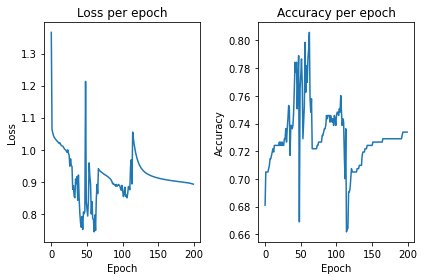

In [25]:
# Plot the evolution of the loss and accuracy per epoch.
plt.figure()
plt.subplot(121)
plt.plot(history.history['loss'])
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.title('Accuracy per epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()

In [26]:
# A generator with the test data is needed
steps_test = len(X_test) # Number of test recordings
test_gen = X_generator(X_test,y_test) # Generator with the test data
model.evaluate(test_gen,steps=steps_test) # Overall scores for the test set

105/105 [==============================] - 8s 76ms/step - loss: 1.0304 - accuracy: 0.7048


[1.030411720275879, 0.7047619223594666]

In [27]:
# Compute the predictions for the training and test sets
y_train_pred = model.predict(train_gen,steps=steps_train)
y_test_pred = model.predict(test_gen,steps=steps_test)

Text(0.5, 1.0, 'Confusion matrix (test set)')

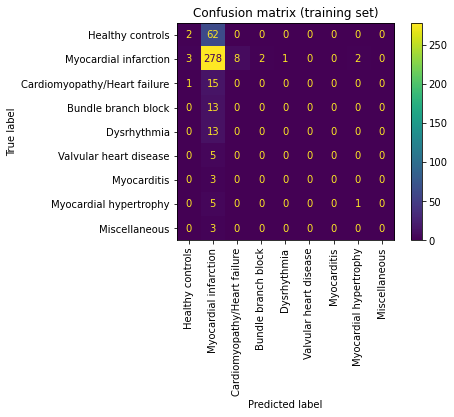

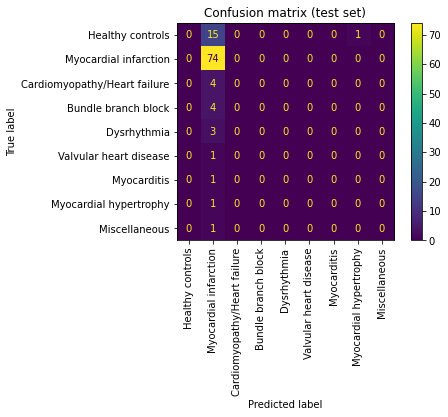

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Display the confusion matrix for the training set
cm_train = ConfusionMatrixDisplay.from_predictions(y_train.argmax(axis=1), y_train_pred.argmax(axis=1), display_labels=target_labels,xticks_rotation="vertical")
plt.title('Confusion matrix (training set)')

# Display the confusion matrix for the test set
cm_test = ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), y_test_pred.argmax(axis=1), display_labels=target_labels,xticks_rotation="vertical")
plt.title('Confusion matrix (test set)')

### Analysis of the results

First of all, regarding the training process, we can see that after 200 epochs the model has not converged in terms of loss, with strong oscillations around 0.9. It will probably require to adjust the learning rate and the number of epochs. With the considered model, we can see that the overall accuracy is around 70%, which is similar to the one obtained by the SVC.

As well as in the SVC algorithm, the myocardial infarction is perfectly classified with the LSTM architecture (that means that the sensitivity for this category is 100%), although results get much worse when analyzing the rest of the categories associated to cardiac pathology. The LSTM-based model was completely unable to correctly classify those pathologies. Moreover, the specificity for this classifier was also 0%, which means that this model is unable to detect healthy subjects.

Once again, with these results, we can conclude that the LSTM-based architecture proposed cannot be considered as good choice of screening algorithm. Besides, training lasts more than 3 hours in a computer with a high-end GPU, which does not worth it taking into account that the results were similar to the SVC (faster classification algorithm).

## Limitations of this challenge and conclusions

Once we have reached this point, is time to discuss the different results, limitations and work that should be done in the future.

What we wanted with this work is to be able to design and evaluate the performance of some Machine Learning and Deep Learning algorithms in an ECG classification task. One of the main aim of AI in the clinical practice is to help clinicians to decide a diagnostic, and the screening process is the first part of the process in which an algorithm should have a great performance. However, in this Challenge, we were completely unable to do that.

Does it means that AI has nothing to do in this process? Of course it has! We have to take into account several limitations that this Challenge has:
* The first one is the high database imbalance. This database has a huge amount of myocardial infarction examples, and the different algorithms performs well when predicting this category. However, the other categories are not well represented, and it decreased the ability of the models to generalize.
* The second one is the methodology to obtain the features (ML methods). We have computed some of the most simple ECG descriptors available, and there are many others that should be tested. For example, HRV-based features can be used to increase the performance of the classifiers. Moreover, the R-peaks-detection algorithm is far from perfect. The algorithm used works well in sinus rhythm, but it is not reliable in arrhythmic cases.
* The third one is the architecture of the LSTM network (DL methods). In this work we decided to test a very simple architecture, since computation times are quite large. More complex architectures should be tested, including a higher number of layers, hybrid CNN-LSTM architectures, hyperparameter tuning, etc. 
* The forth one is the lack of a validation set. We decided to not to use this set, since the dataset is not so big, and the more data we have for training, the better results could have in the test set. However, this dataset is needed to better adjust the hyperparameters of both ML and LSTM models.
* The last one, and related with the previous point, is the lack of cross-validation scheme. The number of subjects to which the ECG was recorded has been proved to be not enough in this task, so the selection of the examples that goes to the training or the test set can be crucial to obtain a good classification performance. We should implement a CrossValidation scheme in order to give statistical significance to the obtained results.

In conclusion, we have to be aware that working with real data is a challenge by itself. Of course, a bigger dataset could help to get better results, but developing a good AI tool to help in clinical diagnosis relies in other factors, like the computation resources, the data quality and pre-processing (garbage input... garbage output), and of course, and in-depth study of the ECG of the different pathologies.